# Arpit Gour


# Sales Prediction using SARIMA-LSTM Hybrid Model 

# $$ \color{red} { \text{PROJECT} }$$

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
import itertools
import warnings
warnings.filterwarnings("ignore")


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

import seaborn as sns
import random
import csv

from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler

### The Dataset

In [2]:
data = pd.read_excel('superstore_data.xlsx') # reading the data

In [3]:
data.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [4]:
data['Category'].unique() # Getting the unique category

array(['Furniture', 'Office Supplies', 'Technology'], dtype=object)

In [5]:
data.groupby('Category')['Sales'].count() # Grouping the sales by category

Category
Furniture          2121
Office Supplies    6026
Technology         1847
Name: Sales, dtype: int64

In [6]:
data = data[['Order Date', 'Category','Sales']]
data = data.sort_values('Order Date').reset_index(drop=True)

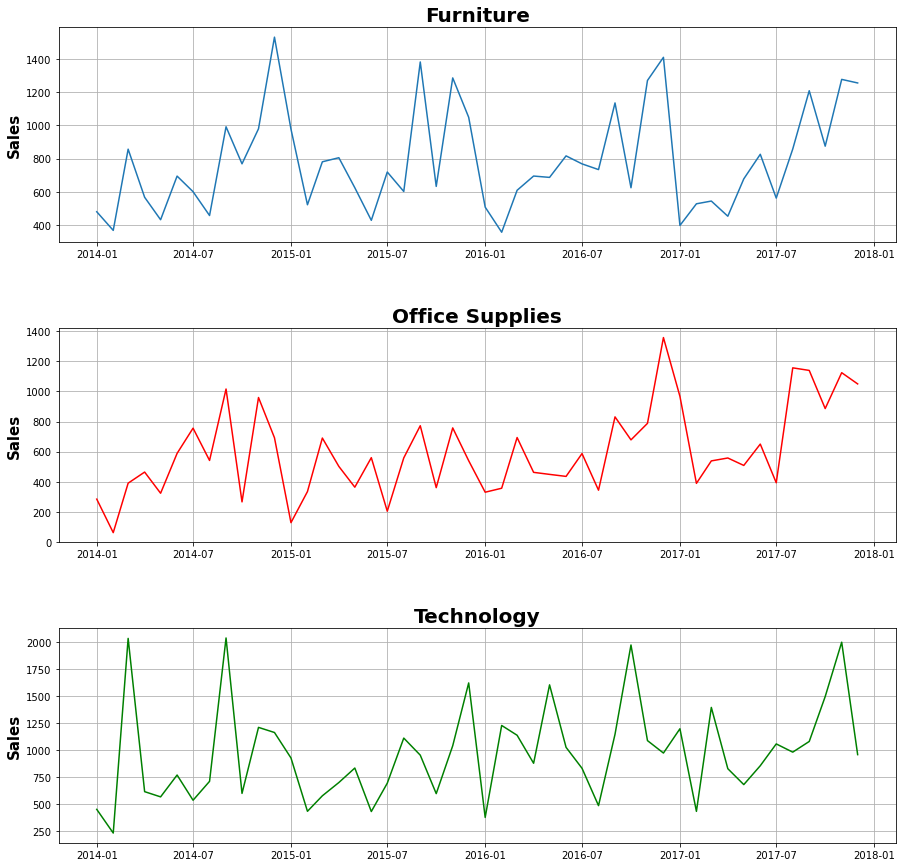

In [7]:
# Separating the data catecory wise

df_frn = data[data.Category=="Furniture"].reset_index(drop=True).drop('Category',axis=1) 
df_off = data[data.Category=="Office Supplies"].reset_index(drop=True).drop('Category',axis=1)
df_tch = data[data.Category=="Technology"].reset_index(drop=True).drop('Category',axis=1)

# summing the daily sales
df_frn = df_frn.groupby('Order Date')['Sales'].sum().reset_index()
df_off = df_off.groupby('Order Date')['Sales'].sum().reset_index()
df_tch = df_tch.groupby('Order Date')['Sales'].sum().reset_index()

# Settng index
df_frn = df_frn.set_index('Order Date')
df_off = df_off.set_index('Order Date')
df_tch = df_tch.set_index('Order Date')

# grouping the sales to get monthly sales
frn = df_frn['Sales'].resample('MS').mean()
off = df_off['Sales'].resample('MS').mean()
tch = df_tch['Sales'].resample('MS').mean()


# plottting the sales of different categories
fig1 = plt.figure(figsize = (15,15))
fig1.subplots_adjust(hspace=0.4)

fig11 = fig1.add_subplot(311)
fig11.plot(frn)
fig11.set_ylabel("Sales", size = 15, weight = "bold")
fig11.set_title("Furniture",size = 20, weight = "bold")
fig11.grid()

fig12 = fig1.add_subplot(312)
fig12.plot(off,'r')
fig12.set_ylabel("Sales", size = 15, weight = "bold")
fig12.set_title("Office Supplies",size = 20, weight = "bold")
fig12.grid()

fig13 = fig1.add_subplot(313)
fig13.plot(tch,'g')
fig13.set_ylabel("Sales", size = 15, weight = "bold")
fig13.set_title("Technology",size = 20, weight = "bold")
fig13.grid()

# From the Avg monthly sales plot shown above, we can say that furniture sales is showing seasonality in its trend.
# Hence a SARIMA Model can be applied to predict the future sales of the Furnitures.

In [8]:
y_train = frn[:len(frn) - 11] # taking first 37 months sales as training data
y_test = frn[len(frn) - 11:]  # taking last 11 months sales as testing data

# ACF and PACF

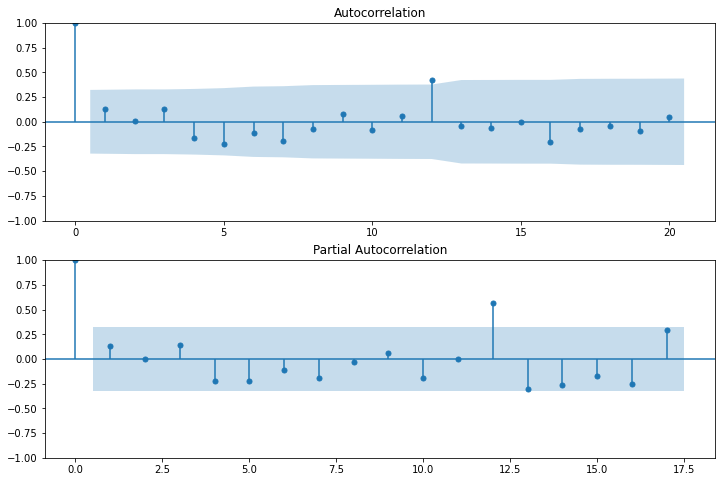

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig2, ax  = plt.subplots(2 , figsize = (12,8))

ax[0] = plot_acf(y_train, ax = ax[0], lags=20)

ax[1] = plot_pacf(y_train, ax = ax[1], lags=17)

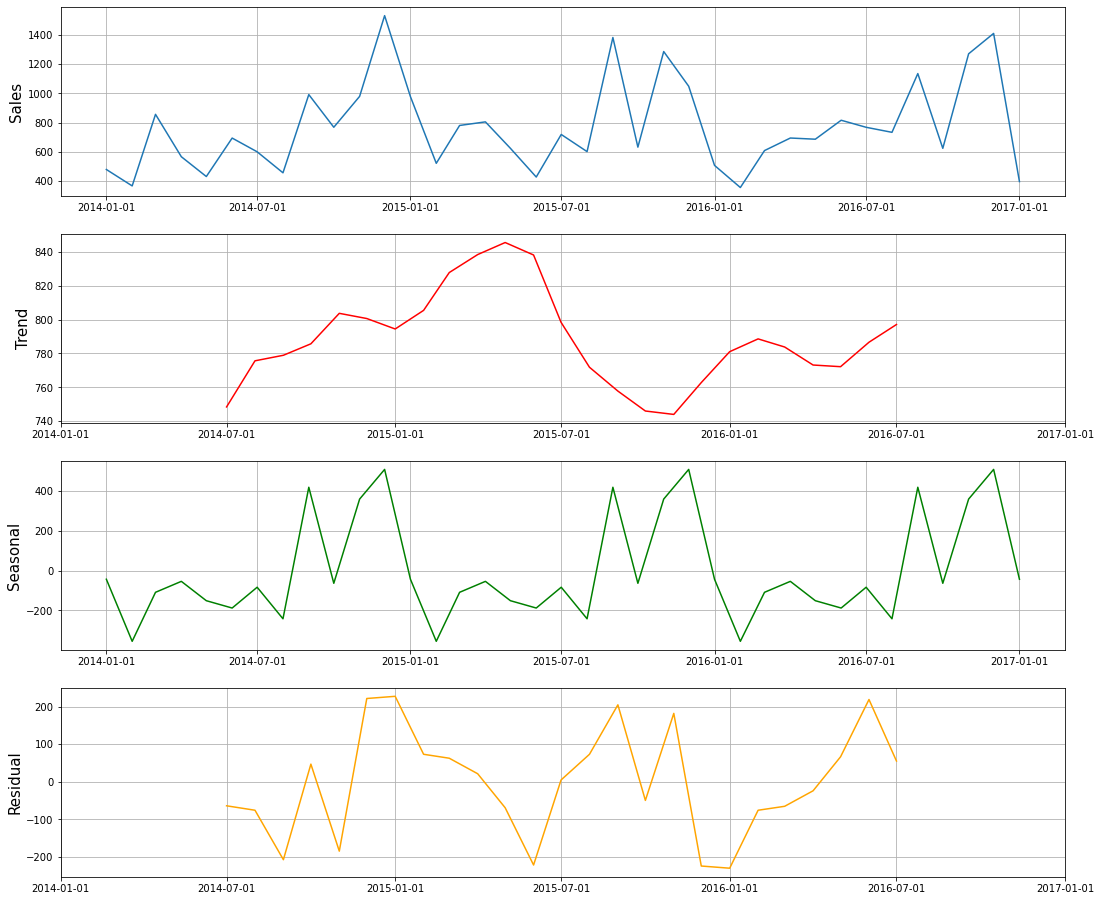

In [10]:
ts_decomp = sm.tsa.seasonal_decompose(y_train, model='additive') # decomposing 

ts_residuals = y_train - ts_decomp.trend - ts_decomp.seasonal # residual component

ts_seasonal =  ts_decomp.seasonal # seasonal component

plt.figure(figsize = (18,16))

plt.subplot(411)
plt.plot(y_train)
plt.ylabel("Sales", size = 15)
plt.xticks(y_train.index[0:37:6])
plt.grid()

plt.subplot(412)
plt.plot(ts_decomp.trend,'r')
plt.ylabel("Trend", size = 15)
plt.xticks(y_train.index[0:37:6])
plt.grid()

plt.subplot(413)
plt.plot(ts_decomp.seasonal,'g')
plt.ylabel("Seasonal", size = 15)
plt.xticks(y_train.index[0:37:6])
plt.grid()

plt.subplot(414)
plt.plot(ts_residuals ,'orange')
plt.ylabel("Residual", size = 15)
plt.xticks(y_train.index[0:37:6])
plt.grid()



plt.show()

In [11]:
# paramenters for sarima
p = range(0,2)
d = range(0,2)
q = range(0,2)

pdq = list(itertools.product(p,d,q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq] # ALl combinations

# SARIMA MODEL

In [12]:
def sarima_train(train_data, pdq, seasonal_pdq):
    metric_aic_dict = dict()

    for pm in pdq:
        for pm_seasonal in seasonal_pdq:
            try:
                model = sm.tsa.statespace.SARIMAX(train_data,
                                                 order = pm,
                                                 seasonal_order = pm_seasonal,
                                                 enforce_stationaryity = False,
                                                 enforce_invertibility = False)
                model_aic = model.fit()
    #             print('ARIMA{} * {}12 - AIC:{}'.format(pm, pm_seasonal, model_aic.aic))
                metric_aic_dict.update({(pm,pm_seasonal):model_aic.aic})
            except:
                continue
    best_params =  min(metric_aic_dict, key=metric_aic_dict.get)
    
    model = sm.tsa.statespace.SARIMAX(train_data,
                                 order = best_params[0],
                                 seasonal_order = best_params[1],
                                 )
    model.aic = model.fit()
    print(model_aic.summary().tables[1])
    
    model.aic.plot_diagnostics(figsize = (18,12))
    plt.show()
    
    return model.aic



## Training the SARIMA Model

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1662      0.369      0.450      0.653      -0.558       0.890
ma.L1         -1.0000   3052.999     -0.000      1.000   -5984.769    5982.769
ar.S.L12      -0.1219      0.504     -0.242      0.809      -1.110       0.866
ma.S.L12      -1.0002   3052.885     -0.000      1.000   -5984.544    5982.544
sigma2      2.752e+04      0.111   2.48e+05      0.000    2.75e+04    2.75e+04


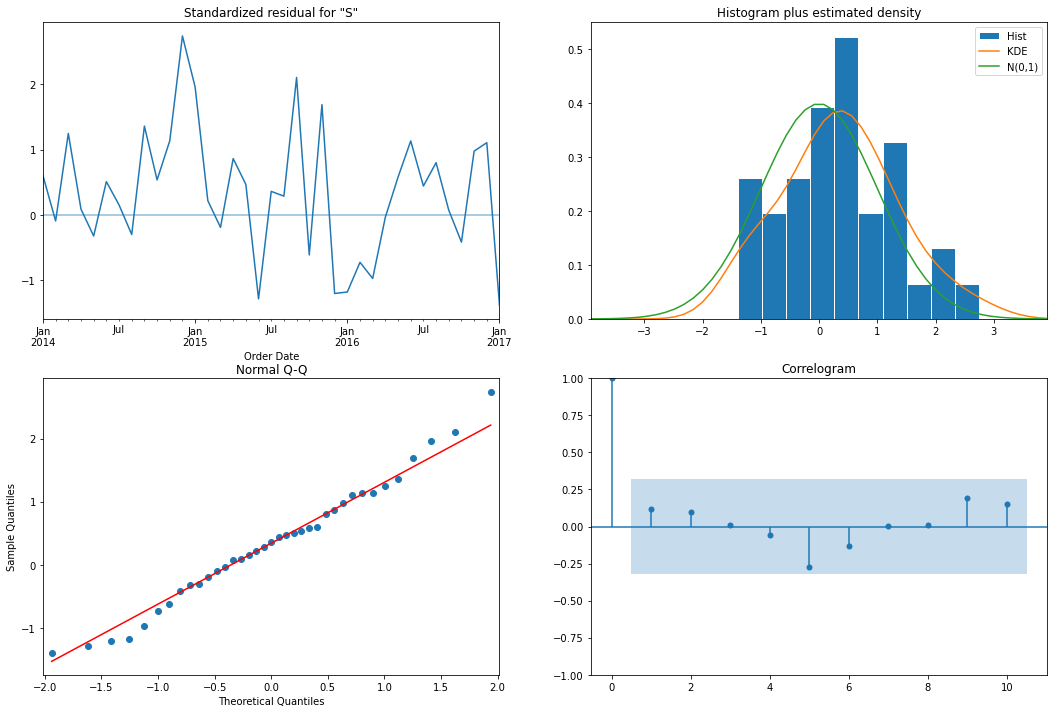

In [13]:
model_aic = sarima_train(y_train, pdq, seasonal_pdq) # Training the sarima model

## Predicting the Future Sales using SARIMA Model

In [14]:
def sarima_forecast(model_aic):


    forecast = model_aic.get_prediction(start = pd.to_datetime('2017-02-01'), dynamic = False)
    predictions = forecast.predicted_mean
    
    forecast = model_aic.get_forecast(steps = 11)

    prediction = forecast.predicted_mean
    
    return prediction
    

prediction = sarima_forecast(model_aic) # getting predictions

actual = y_test['2017-02-01':] # actual values of test

rmse = np.sqrt(((prediction - actual )**2).mean())

print(f'RMSE : { round(rmse,2)}')
print('MAE : ',(prediction - actual ).abs().mean())

RMSE : 157.53
MAE :  139.4684366427431


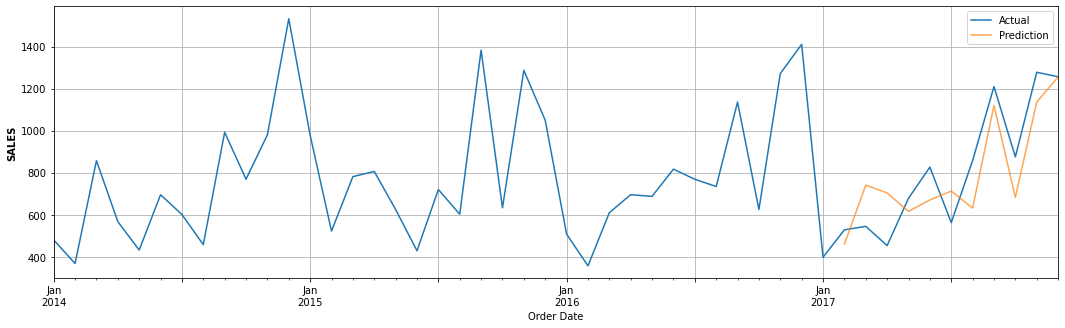

In [15]:
# Plotting the time series
fig = frn.plot(label = 'Actual', figsize = (18,5))

prediction.plot(ax = fig, label = 'Prediction', alpha = .7, figsize = (18,5))
plt.xticks(frn.index[0:48:6])
plt.ylabel('SALES', weight = 'bold')
plt.legend()
plt.grid()
plt.show()

# Long Short-term Memory Model

In [16]:
def model_LSTM(n_features, n_input, scaled_train):
    
    generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=8)

    # define model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    print(model.summary())
    
    model.fit(generator,epochs=300,verbose=0)
    
    loss_per_epoch = model.history.history['loss']
#     plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

    last_train_batch = scaled_train[-n_input:]
    last_train_batch = last_train_batch.reshape((1, n_input, n_features))
    model.predict(last_train_batch)
    
    test_predictions = []

    first_eval_batch = scaled_train[-n_input:]
    current_batch = first_eval_batch.reshape((1, n_input, n_features))

    for i in range(len(ltest)):
    
        # get the prediction value for the first batch
        current_pred = model.predict(current_batch)[0]
        
        # append the prediction into the array
        test_predictions.append(current_pred) 
        
        # use the prediction to update the batch and remove the first value
        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    
    
    
    true_predictions = scaler.inverse_transform(test_predictions)
    
    return true_predictions.reshape(11,)



In [17]:
ltrain = frn.iloc[:37].values.reshape(-1,1)
ltest = frn[37:].values.reshape(-1,1)

scaler = MinMaxScaler()
scaler.fit(ltrain)
scaled_train = scaler.transform(ltrain)
scaled_test = scaler.transform(ltest)

In [18]:
lstm_preds = model_LSTM(1,10,scaled_train)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
1/1 [==============================] - 0s 47ms/step


In [19]:
print('RMSE : ',np.sqrt(((actual - lstm_preds)**2).mean()))
print('MAE : ', (actual - lstm_preds).abs().mean())

# plt.plot(actual.values)
# plt.plot(lstm_preds)
# plt.show()

RMSE :  551.571784124813
MAE :  324.59005904011093


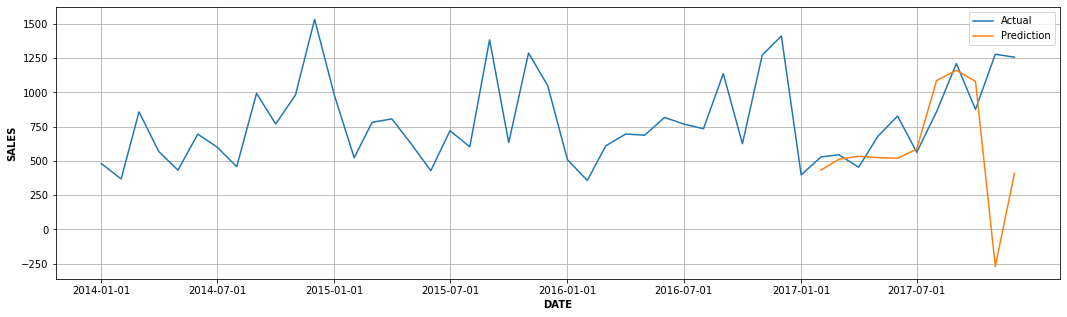

In [20]:
pd_lstm = pd.DataFrame(lstm_preds)

fig = plt.figure(figsize = ( 18,5))
plt.plot(frn.index[0:48], frn.values,label='Actual')

plt.plot(frn.index[37:48],pd_lstm.values,label='Prediction')
plt.xticks(frn.index[0:48:6])
plt.ylabel('SALES', weight = 'bold')
plt.xlabel('DATE', weight = 'bold')
plt.legend()
plt.grid()
plt.show()

# ....................................................................................................................

# SARIMA-LSTM Hybrid Model

In [21]:
ts_lstm = sm.tsa.seasonal_decompose(frn, model='additive') # getting the seasonal component
resid =  frn - ts_lstm.seasonal  # subracting the seasonal component to get non sesonal component

# preparing the non seasonal component for training
htrain = resid.iloc[:37].values.reshape(-1,1)
htest = resid[37:].values.reshape(-1,1)

scaler = MinMaxScaler()
scaler.fit(htrain)
h_scaled_train = scaler.transform(htrain)
h_scaled_test = scaler.transform(htest)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1       4.329e-06    4.9e-24   8.84e+17      0.000    4.33e-06    4.33e-06
ma.L1       -1.82e-11   4.95e-24  -3.67e+12      0.000   -1.82e-11   -1.82e-11
ar.S.L12   -4.686e-16   1.24e-34  -3.78e+18      0.000   -4.69e-16   -4.69e-16
ma.S.L12    4.686e-16   6.07e-36   7.72e+19      0.000    4.69e-16    4.69e-16
sigma2      7.273e-10   5.33e-10      1.364      0.173   -3.18e-10    1.77e-09


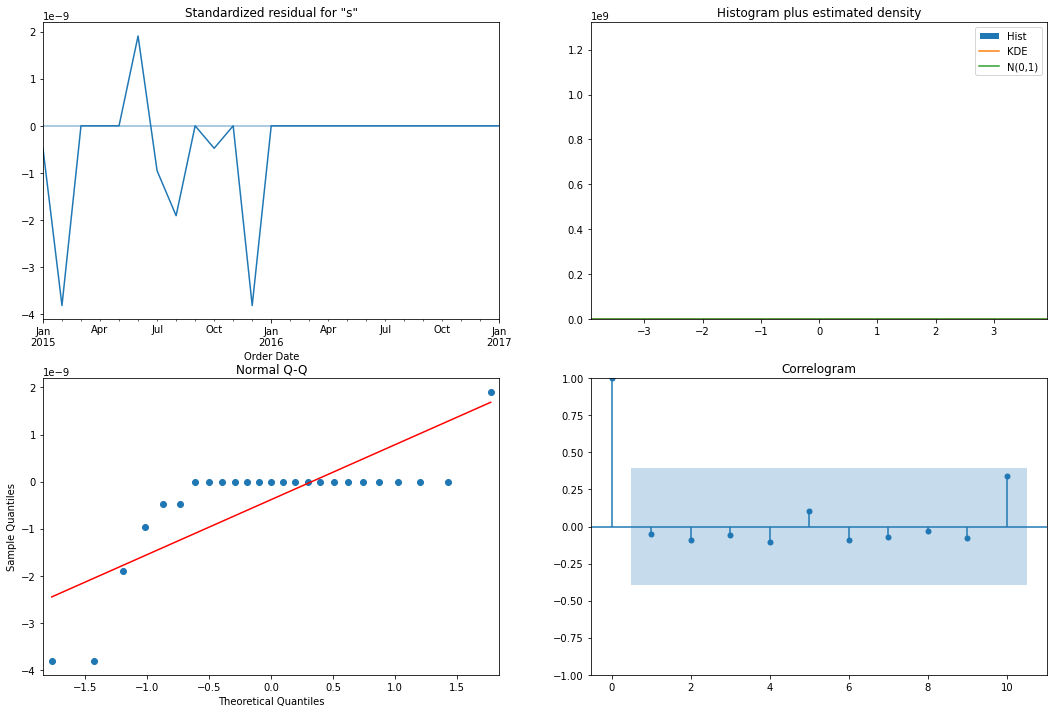

In [22]:
model_aic2 = sarima_train(ts_seasonal,pdq,seasonal_pdq)  # training the sarima model for seasonal part

### Forecasting the seasonal part

In [23]:
pred_hybrid_seasonal = sarima_forecast(model_aic2).to_numpy()

### Forecasting the non seasonal part

In [24]:
pred_hybrid_lstm = model_LSTM(1,10,h_scaled_train) # 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                10400     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
1/1 [==============================] - 0s 41ms/step


### Adding the seasonal and non seasonal

In [25]:
hybrid_preds =  pred_hybrid_seasonal + pred_hybrid_lstm # Adding the seasonal and non seasonal part

print('RMSE : ',np.sqrt(((actual - hybrid_preds)**2).mean()))
print('MAE :',(actual - hybrid_preds).abs().mean())

RMSE :  165.63993438568346
MAE : 137.1768401552959


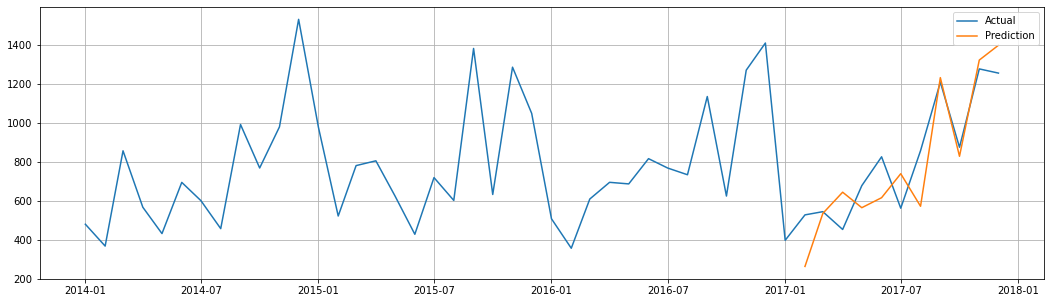

In [26]:

fig = plt.figure(figsize = ( 18,5))
plt.plot(frn.index[0:48],frn.values, label = 'Actual')
plt.plot(frn.index[37:48],hybrid_preds, label = 'Prediction')
plt.legend()
plt.grid()
plt.show()